#Import

Install

In [1]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import

In [1]:
import datetime 
import requests
import math
import sklearn
import itertools
from sklearn.linear_model import LinearRegression
from itertools import product
from datetime import datetime

import pandas as pd
import numpy as np 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from matplotlib.pylab import rcParams

import pmdarima as pm
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

#Data

In [3]:
df_raw = pd.read_csv('../main/data/20211022_수요예측_hackathon_data.csv', encoding = 'cp949')
df = df_raw
df

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형
...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,male,경형
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,female,준중형
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,male,경형
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,unknown,소형SUV


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457067 entries, 0 to 457066
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   region1                457067 non-null  object
 1   region2                457067 non-null  object
 2   reservation_return_at  457067 non-null  object
 3   reservation_start_at   457067 non-null  object
 4   age_group              457067 non-null  int64 
 5   gender                 457067 non-null  object
 6   car_model              457067 non-null  object
dtypes: int64(1), object(6)
memory usage: 24.4+ MB


In [5]:
df['reservation_return_at'] = pd.to_datetime(df['reservation_return_at'])
df['reservation_start_at'] = pd.to_datetime(df['reservation_start_at'])

In [6]:
df.isnull().sum()

region1                  0
region2                  0
reservation_return_at    0
reservation_start_at     0
age_group                0
gender                   0
car_model                0
dtype: int64

In [7]:
df.dropna(axis = 0, inplace = True)

In [8]:
df_경기도 = df[df['region1'] == '경기도']
df_경기도

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,male,소형SUV
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4,male,준중형SUV
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,male,소형SUV
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3,female,소형SUV
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,male,준중형
...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,male,경형
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,female,준중형
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,male,경형
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,unknown,소형SUV


In [9]:
df_경기도['used_time'] = df_경기도['reservation_return_at'] - df_경기도['reservation_start_at']
df_경기도['reservation_return_date'] = df_경기도['reservation_return_at'].dt.to_period(freq = 'D')
df_경기도['reservation_start_date'] = df_경기도['reservation_start_at'].dt.to_period(freq = 'D')
df_경기도['week'] = df_경기도['reservation_start_date'].dt.dayofweek

In [10]:
df_경기도

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,male,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4,male,준중형SUV,0 days 23:50:00,2019-05-14,2019-05-13,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,male,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3,female,소형SUV,0 days 09:24:19,2019-04-07,2019-04-07,6
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,male,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4
...,...,...,...,...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,male,경형,0 days 00:25:29,2019-09-14,2019-09-14,5
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,female,준중형,0 days 21:00:00,2019-07-25,2019-07-24,2
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,male,경형,0 days 01:08:09,2019-07-14,2019-07-14,6
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,unknown,소형SUV,0 days 00:15:37,2019-06-20,2019-06-20,3


In [11]:
df_경기도['gender'] = df_경기도['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_경기도['is_weekend'] = df_경기도['week'].apply(lambda x: 0 if x < 5 else 1)
df_경기도 = df_경기도[df_경기도['age_group'] < 3]
df_경기도

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week,is_weekend
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,0,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,0,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4,0
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,0,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4,0
44110,경기도,광명시,2019-03-31 01:59:40+00:00,2019-03-30 21:30:00+00:00,2,1,소형SUV,0 days 04:29:40,2019-03-31,2019-03-30,5,1
44111,경기도,광명시,2019-09-20 12:39:13+00:00,2019-09-20 09:10:00+00:00,2,1,준중형,0 days 03:29:13,2019-09-20,2019-09-20,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457060,경기도,고양시 일산서구,2019-05-25 13:26:28+00:00,2019-05-25 13:00:00+00:00,1,1,소형SUV,0 days 00:26:28,2019-05-25,2019-05-25,5,1
457061,경기도,고양시 일산서구,2019-04-14 00:20:24+00:00,2019-04-13 18:50:00+00:00,1,0,경형,0 days 05:30:24,2019-04-14,2019-04-13,5,1
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,0,경형,0 days 00:25:29,2019-09-14,2019-09-14,5,1
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,0,경형,0 days 01:08:09,2019-07-14,2019-07-14,6,1


In [12]:
df_경기도['region2'].unique()

array(['광명시', '구리시', '김포시', '양평군', '하남시', '화성시', '남양주시', '의정부시',
       '고양시\u3000덕양구', '성남시\u3000분당구', '성남시\u3000수정구', '성남시\u3000중원구',
       '안양시\u3000동안구', '안양시\u3000만안구', '고양시\u3000일산동구', '고양시\u3000일산서구'],
      dtype=object)

#함수

In [13]:
def plot_rolling_statistics(timeseries, window = 12):
    rolmean = timeseries.rolling(window = window).mean()
    rolstd = timeseries.rolling(window = window).std()

    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

In [14]:
def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag = 'AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

In [15]:
def sarima(data):
# 데이터의 컬럼 및 이름 조정
    df_function = pd.DataFrame(data['reservation_start_date'].value_counts())
    df_function.reset_index(inplace = True)
    df_function.columns = ['Date', 'Demand']
    df_function.sort_values(by = ['Date'], inplace = True)
    df_function['Date'] = df_function['Date'].astype(str)
    df_function.set_index('Date', inplace = True)

# 함수의 변수 및 p-value를 통해 stationary 여부 확인    
    ts = df_function['Demand']
    # plot_rolling_statistics(ts, window = 12)
    augmented_dickey_fuller_test(ts)

# time series를 trend, seasonal, residual로 분해
    decomposition = seasonal_decompose(ts, model = 'multiplicative', period = 30)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label = 'Original')
    plt.legend(loc = 'best')
    plt.subplot(412)
    plt.plot(trend, label = 'Trend')
    plt.legend(loc = 'best')
    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonal')
    plt.legend(loc = 'best')
    plt.subplot(414)
    plt.plot(residual, label = 'Residuals') 
    plt.legend(loc = 'best')
    plt.tight_layout()

    residual.dropna(inplace = True)
    # augmented_dickey_fuller_test(residual)

# 훈련 데이터와 테스트 데이터로 분리
    train_data, test_data = ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]
    # plt.figure(figsize = (10, 6))
    # plt.plot(ts, c = 'r', label = 'training dataset')
    # plt.plot(test_data, c = 'b', label = 'test dataset')
    # plt.legend()

    # plot_acf(ts)
    # plot_pacf(ts)
    # plt.show()

# 미분을 하여 sarima에 필요한 d 변수 결정 
    diff_1 = ts.diff(periods = 1).iloc[1:]
    # diff_1.plot(title = 'Difference 1st')
    # augmented_dickey_fuller_test(diff_1)

# Sarima Modeling
    model = pm.auto_arima(train_data, seasonal = True, m = 7, D = 1)
    print(model)
    print(model.params())
    print(model.aic())

    sarima_pred, conf_int = model.predict(n_periods = test_data.shape[0], return_conf_int = True)
    sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(test_data, sarima_pred))
# 모델의 RMSE, MSE 값   
    print(f'Test RMSE: {sarima_rmse}\n')
    print(f'MSE: {sarima_rmse**2}\n')

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
    plt.xticks(rotation = 45)
    loc = plticker.MultipleLocator(base = 7.0) 
    ax.xaxis.set_major_locator(loc)

    plt.plot(train_data[-50:], alpha = 0.5, color = 'black', label = 'training')
    plt.plot(test_data, alpha = 0.5, color = 'red', label = 'actual demand')
    plt.plot(test_data.index.values, sarima_pred, alpha = 0.5, color = 'blue', label = 'predicted demand')
    plt.fill_between(test_data.index.values, conf_int[:, 0], conf_int[:, 1], alpha = 0.1, color = 'b') 
    plt.legend()
    plt.show()

    # model.plot_diagnostics(figsize=(10, 10))
    # plt.show()

#분석

A 지역

In [21]:
df_A = df_경기도[(df_경기도['region2'] == '김포시') | (df_경기도['region2'] == '의정부시') | (df_경기도['region2'] == '고양시\u3000덕양구') | (df_경기도['region2'] == '성남시\u3000분당구')]

# sarima(df_A)

In [23]:
# 데이터의 컬럼 및 이름 조정
df_function = pd.DataFrame(df_A['reservation_start_date'].value_counts())
df_function.reset_index(inplace = True)
df_function.columns = ['Date', 'Demand']
df_function.sort_values(by = ['Date'], inplace = True)
df_function['Date'] = df_function['Date'].astype(str)
df_function.set_index('Date', inplace = True)

Results of Dickey-Fuller Test:
Test Statistic                  -2.543755
p-value                          0.105188
#Lags Used                      13.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64
 ARIMA(1,0,0)(0,1,1)[7] intercept
intercept       1.415219
ar.L1           0.440613
ma.S.L7        -0.826647
sigma2       1561.006253
dtype: float64
3032.766273184477


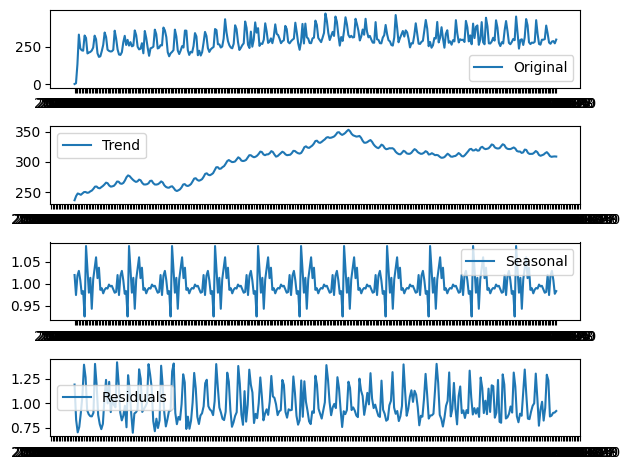

In [25]:

# 함수의 변수 및 p-value를 통해 stationary 여부 확인    
ts = df_function['Demand']
# plot_rolling_statistics(ts, window = 12)
augmented_dickey_fuller_test(ts)

# time series를 trend, seasonal, residual로 분해
decomposition = seasonal_decompose(ts, model = 'multiplicative', period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals') 
plt.legend(loc = 'best')
plt.tight_layout()

residual.dropna(inplace = True)
# augmented_dickey_fuller_test(residual)

# 훈련 데이터와 테스트 데이터로 분리
train_data, test_data = ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]
# plt.figure(figsize = (10, 6))
# plt.plot(ts, c = 'r', label = 'training dataset')
# plt.plot(test_data, c = 'b', label = 'test dataset')
# plt.legend()

# plot_acf(ts)
# plot_pacf(ts)
# plt.show()

# 미분을 하여 sarima에 필요한 d 변수 결정 
diff_1 = ts.diff(periods = 1).iloc[1:]
# diff_1.plot(title = 'Difference 1st')
# augmented_dickey_fuller_test(diff_1)

# Sarima Modeling
model = pm.auto_arima(train_data, seasonal = True, m = 7, D = 1)
print(model)
print(model.params())
print(model.aic())

Test RMSE: 41.43716080978758

MSE: 1717.0382959761955



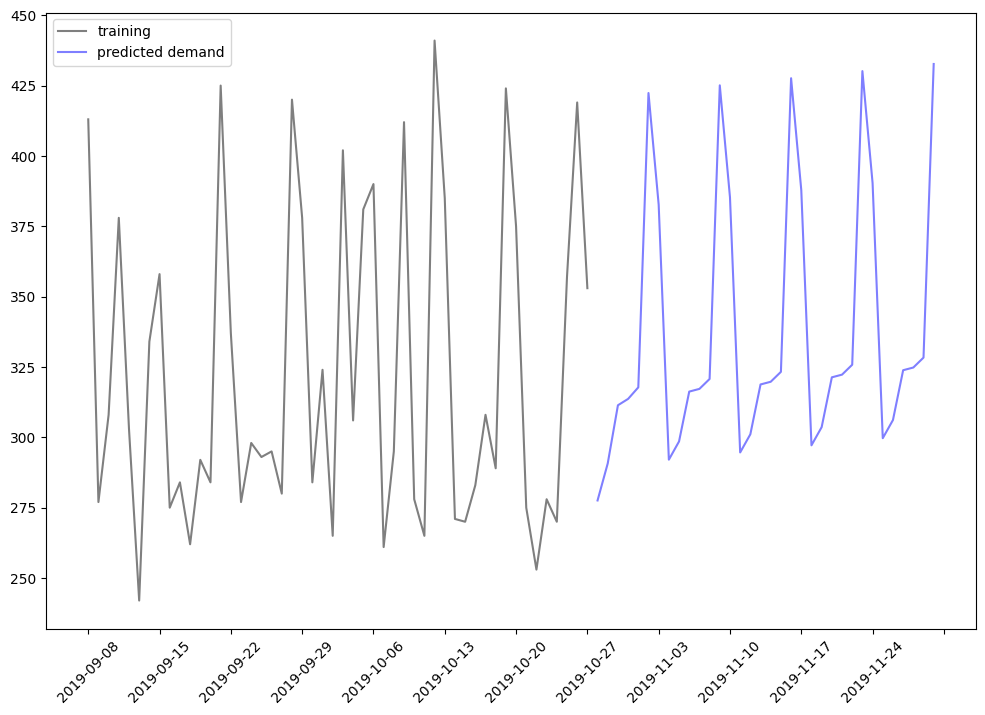

In [28]:
sarima_pred, conf_int = model.predict(n_periods = test_data.shape[0], return_conf_int = True)
sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(test_data, sarima_pred))
# 모델의 RMSE, MSE 값   
print(f'Test RMSE: {sarima_rmse}\n')
print(f'MSE: {sarima_rmse**2}\n')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
plt.xticks(rotation = 45)
loc = plticker.MultipleLocator(base = 7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(train_data[-50:], alpha = 0.5, color = 'black', label = 'training')
#plt.plot(test_data, alpha = 0.5, color = 'red', label = 'actual demand')
plt.plot(test_data.index.values, sarima_pred, alpha = 0.5, color = 'blue', label = 'predicted demand')
# plt.fill_between(test_data.index.values, conf_int[:, 0], conf_int[:, 1], alpha = 0.1, color = 'b') 
plt.legend()
plt.show()

# model.plot_diagnostics(figsize=(10, 10))
# plt.show()

B 지역

Results of Dickey-Fuller Test:
Test Statistic                  -2.124937
p-value                          0.234606
#Lags Used                      14.000000
Number of Observations Used    318.000000
Critical Value (1%)             -3.451082
Critical Value (5%)             -2.870672
Critical Value (10%)            -2.571636
dtype: float64
 ARIMA(0,0,0)(0,1,2)[7]          
ma.S.L7    -0.682585
ma.S.L14   -0.099668
sigma2      9.613356
dtype: float64
1501.6294158410233
Test RMSE: 2.6026801009115608

MSE: 6.7739437076810125



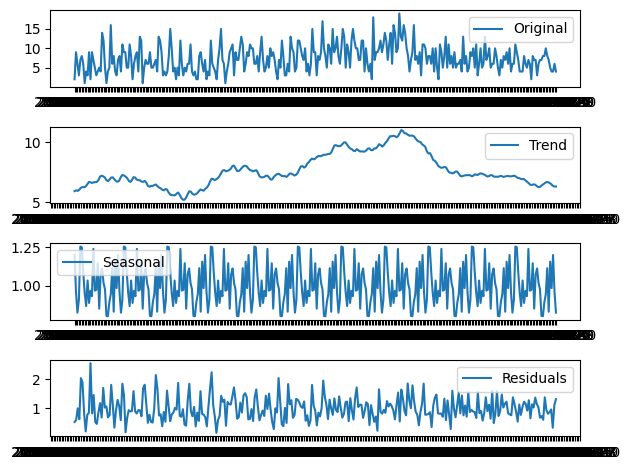

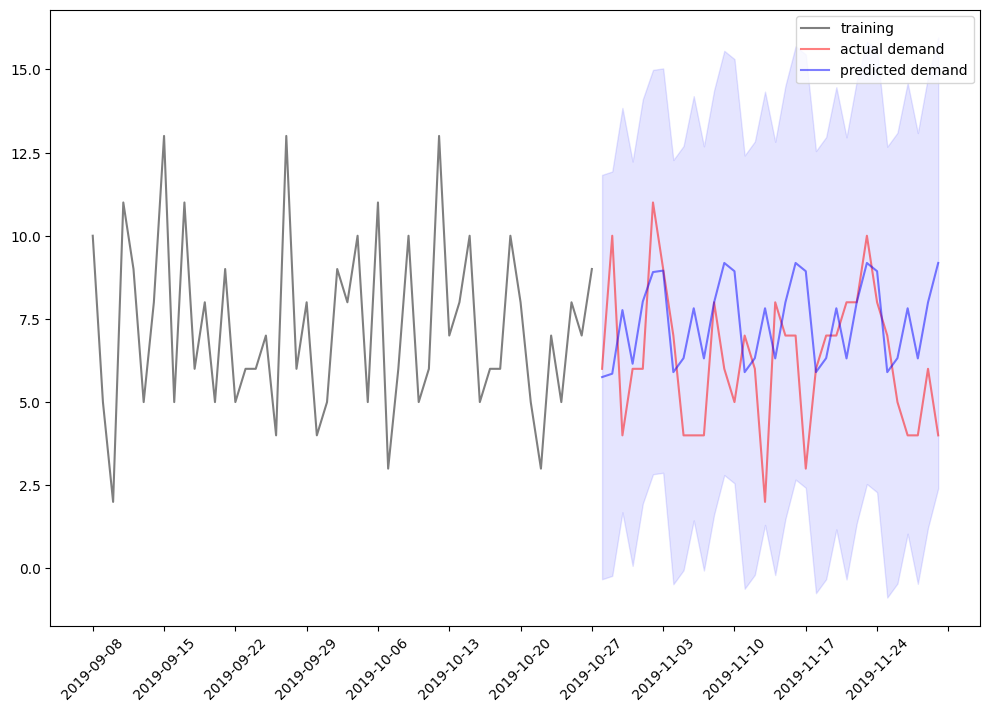

In [17]:
df_B = df_경기도[df_경기도['region2'] == '양평군']
sarima(df_B)

C 지역

D 지역

Results of Dickey-Fuller Test:
Test Statistic                  -3.157696
p-value                          0.022568
#Lags Used                      13.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64
 ARIMA(0,0,2)(0,1,1)[7] intercept
intercept       1.630865
ma.L1           0.556903
ma.L2           0.200071
ma.S.L7        -0.870191
sigma2       1016.951494
dtype: float64
2909.9192806802885
Test RMSE: 43.03110305081839

MSE: 1851.6758297701515



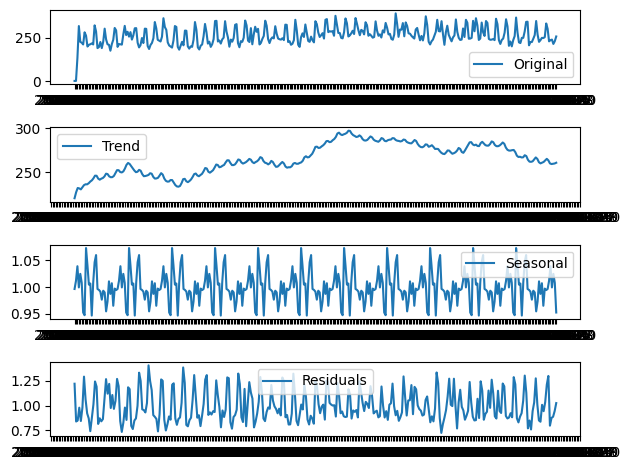

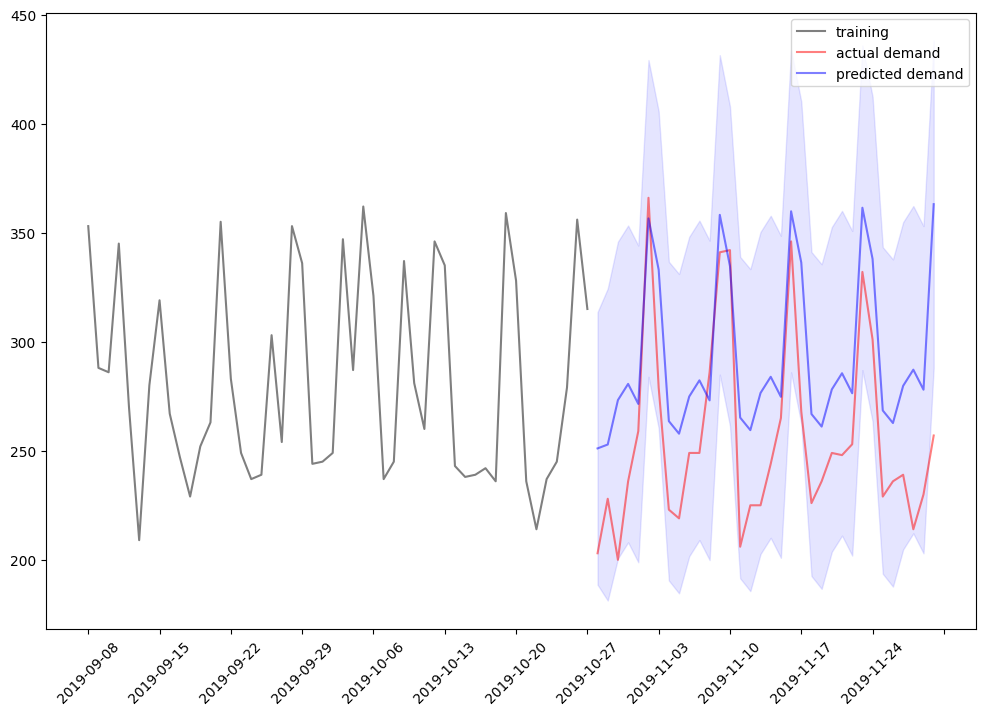

In [18]:
df_D = df_경기도[(df_경기도['region2'] == '광명시') | (df_경기도['region2'] == '하남시') | (df_경기도['region2'] == '안양시\u3000동안구') | (df_경기도['region2'] == '고양시\u3000일산동구') | (df_경기도['region2'] == '고양시\u3000일산서구')]
sarima(df_D)

E 지역

Results of Dickey-Fuller Test:
Test Statistic                  -2.756809
p-value                          0.064713
#Lags Used                      13.000000
Number of Observations Used    324.000000
Critical Value (1%)             -3.450695
Critical Value (5%)             -2.870502
Critical Value (10%)            -2.571545
dtype: float64
 ARIMA(1,0,0)(0,1,1)[7]          
ar.L1        0.555586
ma.S.L7     -0.843267
sigma2     428.236961
dtype: float64
2657.6140634640487
Test RMSE: 20.43817913936925

MSE: 417.7191665329484



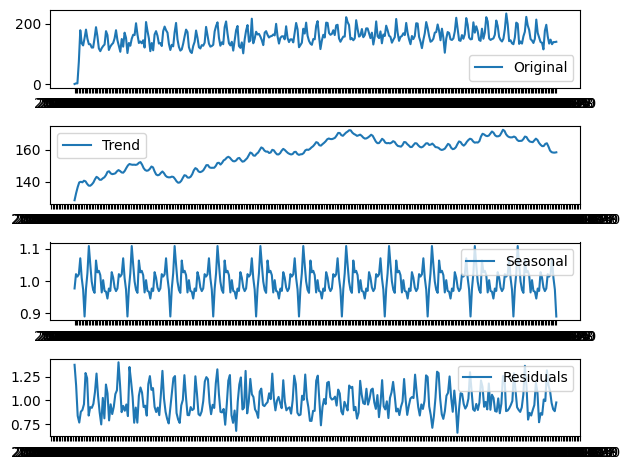

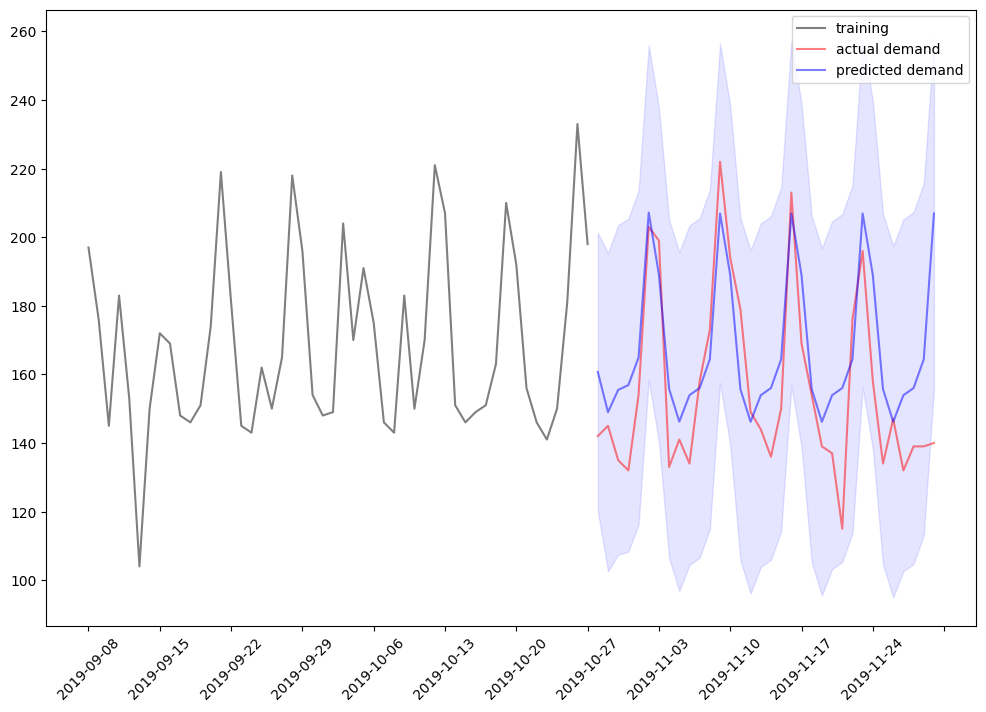

In [19]:
df_E = df_경기도[(df_경기도['region2'] == '화성시') | (df_경기도['region2'] == '남양주시')]
sarima(df_E)

F 지역

G 지역

Results of Dickey-Fuller Test:
Test Statistic                  -2.198438
p-value                          0.206813
#Lags Used                      13.000000
Number of Observations Used    322.000000
Critical Value (1%)             -3.450823
Critical Value (5%)             -2.870558
Critical Value (10%)            -2.571575
dtype: float64
 ARIMA(0,0,1)(0,1,2)[7] intercept
intercept      1.521328
ma.L1          0.261584
ma.S.L7       -0.794082
ma.S.L14      -0.125611
sigma2       509.246098
dtype: float64
2698.3492310196534
Test RMSE: 33.062716699138456

MSE: 1093.143235527489



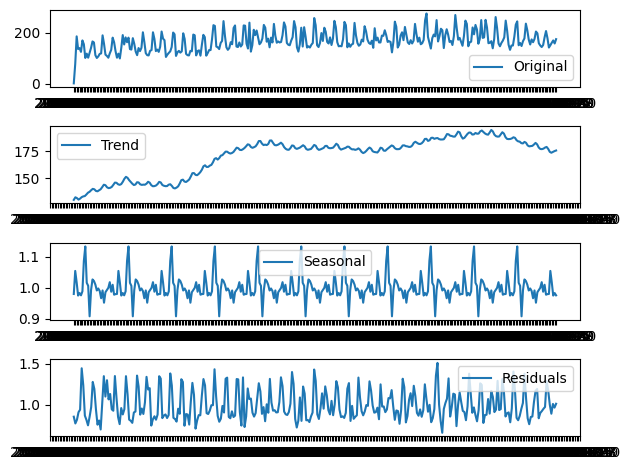

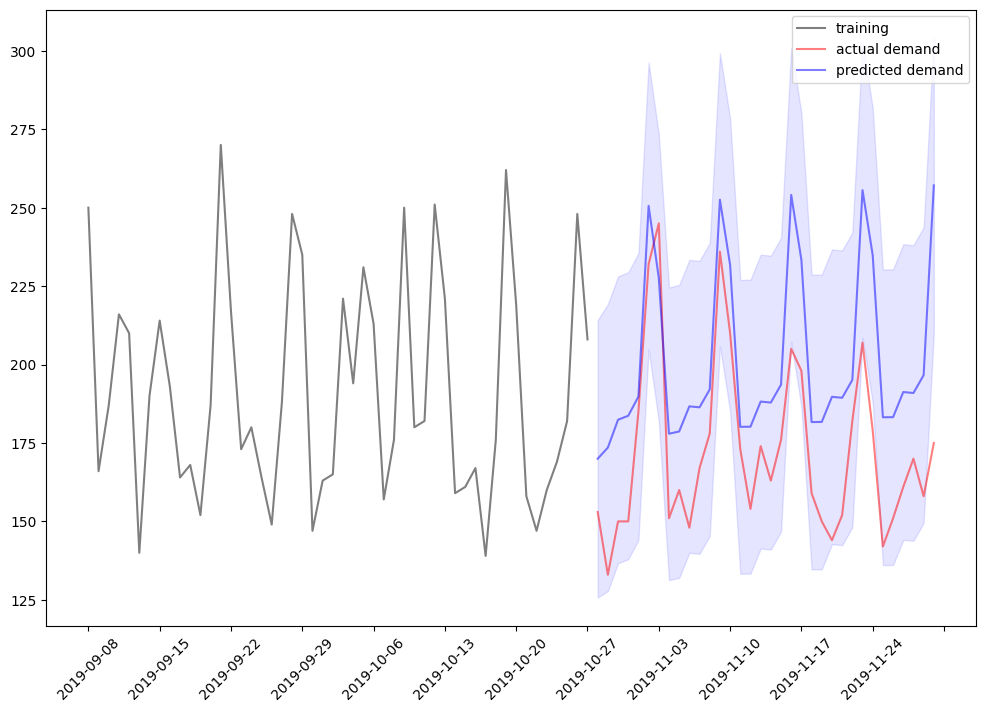

In [20]:
df_G = df_경기도[(df_경기도['region2'] == '구리시') | (df_경기도['region2'] == '성남시\u3000수정구') | (df_경기도['region2'] == '성남시\u3000중원구') | (df_경기도['region2'] == '안양시\u3000만안구')]
sarima(df_G)